## Preprocesamiento de Datos
En este cuaderno, vamos a realizar un preprocesamiento de datos utilizando scikit-learn. El preprocesamiento es una fase crítica en cualquier pipeline de machine learning, ya que asegura que los datos estén en un formato adecuado para entrenar modelos. Al final, también veremos cómo almacenar los objetos de preprocesamiento utilizando joblib y por qué es importante dentro de las prácticas de MLOps.

## Importación de Librerías
Primero, importamos todas las librerías necesarias. Estas incluyen herramientas de manipulación de datos (pandas, numpy), visualización (seaborn, matplotlib), y preprocesamiento (scikit-learn).

In [1]:

# Importamos librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

## Carga de los Datos
Vamos a cargar un conjunto de datos que contiene información demográfica. Este dataset proviene de data_adults.csv, un conjunto de datos comúnmente utilizado para predecir el nivel de ingresos basado en características demográficas.

In [2]:

# Cargamos los datos
Data = pd.read_csv("../Datos/data_adults.csv")
Data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



## Exploración de Datos
Es importante conocer la estructura de los datos antes de preprocesarlos. Vamos a visualizar las primeras filas y también la estructura de tipos de datos en cada columna.

In [3]:
# Vista rápida de los datos
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


## Eliminación de Columnas Irrelevantes
En muchos casos, algunos datos no aportan valor a nuestro modelo o pueden estar altamente correlacionados con otras variables. Aquí, eliminamos la columna fnlwgt (un peso final de la muestra) y education-num (número de años de educación, que ya está representado en la columna education).

In [4]:
# Eliminamos columnas irrelevantes
Data_cop = Data.drop("fnlwgt", axis=1)
Data_cop = Data_cop.drop("education-num", axis=1)

## Separación de Variables y Objetivo
Dividimos los datos en dos partes: las características (X) y la variable objetivo (y), que en este caso es la columna income.

In [5]:

X = Data_cop.drop("income", axis=1)
y = Data_cop['income'].isin(['>50K.','>50K'])
     

## Definición de Estrategia de Preprocesamiento
Aquí definimos diferentes estrategias de preprocesamiento para diferentes tipos de variables:

Las variables categóricas necesitan ser codificadas utilizando técnicas como OneHotEncoder o OrdinalEncoder.
Las variables numéricas pueden ser escaladas utilizando StandardScaler o MinMaxScaler.
También es importante manejar los valores faltantes utilizando imputadores.

In [6]:
# Definimos las variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creamos pipelines de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Usamos ColumnTransformer para combinar ambas transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Creación del Pipeline
Ahora combinamos el preprocesamiento en un pipeline. Esto nos permite encadenar las transformaciones de manera eficiente.

In [7]:

# Definimos el pipeline completo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

## Entrenamiento de un Modelo con el Pipeline
Ahora que tenemos el pipeline de preprocesamiento configurado, vamos a entrenar un modelo. En este caso, usaremos un RandomForestClassifier, un algoritmo robusto y eficiente para tareas de clasificación.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos un nuevo pipeline que incluye el preprocesamiento y el modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entrenamos el pipeline completo en los datos de entrenamiento
model_pipeline.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)

# Evaluamos el rendimiento del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.92      0.90      7414
        True       0.71      0.61      0.66      2355

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [9]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [10]:
modelo_entrenado=model_pipeline['classifier']
preprocessor_entrenado=model_pipeline['preprocessor']

nombres=preprocessor_entrenado.get_feature_names_out()
importancia=modelo_entrenado.feature_importances_

df_features=pd.DataFrame()
df_features['nombres']=nombres
df_features['importancia']=importancia
df_features=df_features.sort_values('importancia',ascending=False)
df_features.head(20)

,nombres,importancia
0,num__age,0.230540
3,num__hours-per-week,0.115249
1,num__capital-gain,0.113666
31,cat__marital-status_Married-civ-spouse,0.068151
51,cat__relationship_Husband,0.048980
2,num__capital-loss,0.038220
33,cat__marital-status_Never-married,0.028357
22,cat__education_Bachelors,0.022635
40,cat__occupation_Exec-managerial,0.020666
46,cat__occupation_Prof-specialty,0.016576


<BarContainer object of 20 artists>

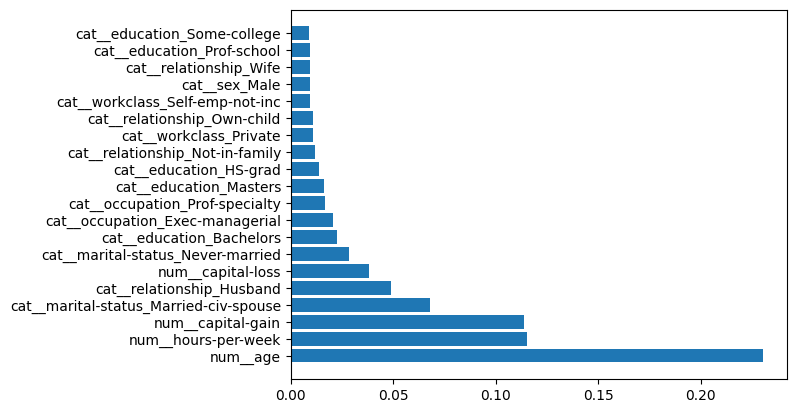

In [11]:
plt.barh(df_features.head(20)['nombres'],df_features.head(20)['importancia'])

## Guardar el Pipeline Completo (Preprocesador + Modelo)
Finalmente, guardamos el pipeline completo (incluyendo el modelo entrenado) en un archivo joblib.

In [12]:
# Guardamos el pipeline completo (preprocesamiento + modelo entrenado)
dump(model_pipeline, 'model_pipeline_rf.joblib')

['model_pipeline_rf.joblib']

## ¿Por qué es esto importante en MLOps?

1. Reproducibilidad: Guardar el pipeline completo asegura que puedas reproducir exactamente las mismas transformaciones y predicciones en diferentes entornos.
2. Automatización: En un entorno MLOps, los pipelines automatizados son clave para la integración continua y el despliegue continuo (CI/CD). Guardar el modelo entrenado con joblib facilita esta automatización.
3. Escalabilidad: Al tener tanto el preprocesamiento como el modelo entrenado almacenados, puedes aplicarlos a nuevos datos sin necesidad de recalcular cada paso, lo que es esencial cuando se trabaja con grandes volúmenes de datos en producción.
4. Consistencia: Evitamos errores derivados de la aplicación inconsistente de transformaciones de datos, garantizando que los datos en producción se traten de la misma forma que en el entrenamiento.

## Optimización de hiperparámetros

Buscamos las mejores combinaciones de hiperparámetros que mejoren el rendimiento del modelo.

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Cargamos los datos
Data = pd.read_csv("../Datos/data_adults.csv")

Data_cop = Data.drop("fnlwgt", axis=1)
Data_cop = Data_cop.drop("education-num", axis=1)

X = Data_cop.drop("income", axis=1)
y = Data_cop['income'].isin(['>50K.','>50K'])

# Definimos las variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creamos pipelines de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Usamos ColumnTransformer para combinar ambas transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [14]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth' : [2,5,10],
    'min_samples_split': [2, 5, 10]
}

model_rf = RandomForestClassifier(random_state = 2024)

##Instanciar la busqueda del mejor modelo
model_busqueda = GridSearchCV(estimator=model_rf, 
                              param_grid = param_grid, 
                              cv= 3, 
                              verbose = 4,
                              scoring = 'f1',
                              n_jobs=-1)

model_pipeline_train = Pipeline(steps=[('preprocessor', preprocessor),
                       ('busqueda', model_busqueda)])

model_pipeline_train.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('busqueda',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=2024),
                              n_jobs=-1,
                              param_grid={'max_depth': [2, 5, 10],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 150, 200]},
                              scoring='f1', verbose=4))])

In [15]:
busqueda_resultado = model_pipeline_train['busqueda']
busqueda_resultado.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2024,
 'verbose': 0,
 'warm_start': False}

In [16]:
y_pred = model_pipeline_train.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.86      0.96      0.91      7414
        True       0.82      0.52      0.63      2355

    accuracy                           0.86      9769
   macro avg       0.84      0.74      0.77      9769
weighted avg       0.85      0.86      0.84      9769



In [17]:
y_pred_train = model_pipeline_train.predict(X_train)

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92     29741
        True       0.83      0.54      0.65      9332

    accuracy                           0.86     39073
   macro avg       0.85      0.75      0.78     39073
weighted avg       0.86      0.86      0.85     39073



Actividad: Buscar el mejor modelo que identifique cuando un adulto gana más de 50k dólares. Usar Naive-Bayes, gradient boosting y regresión logística. Expermientar con máquinas de soporte.

Hay que crear un nuevo ambiente porque shap lo dañó.

Revisar shaply values.
